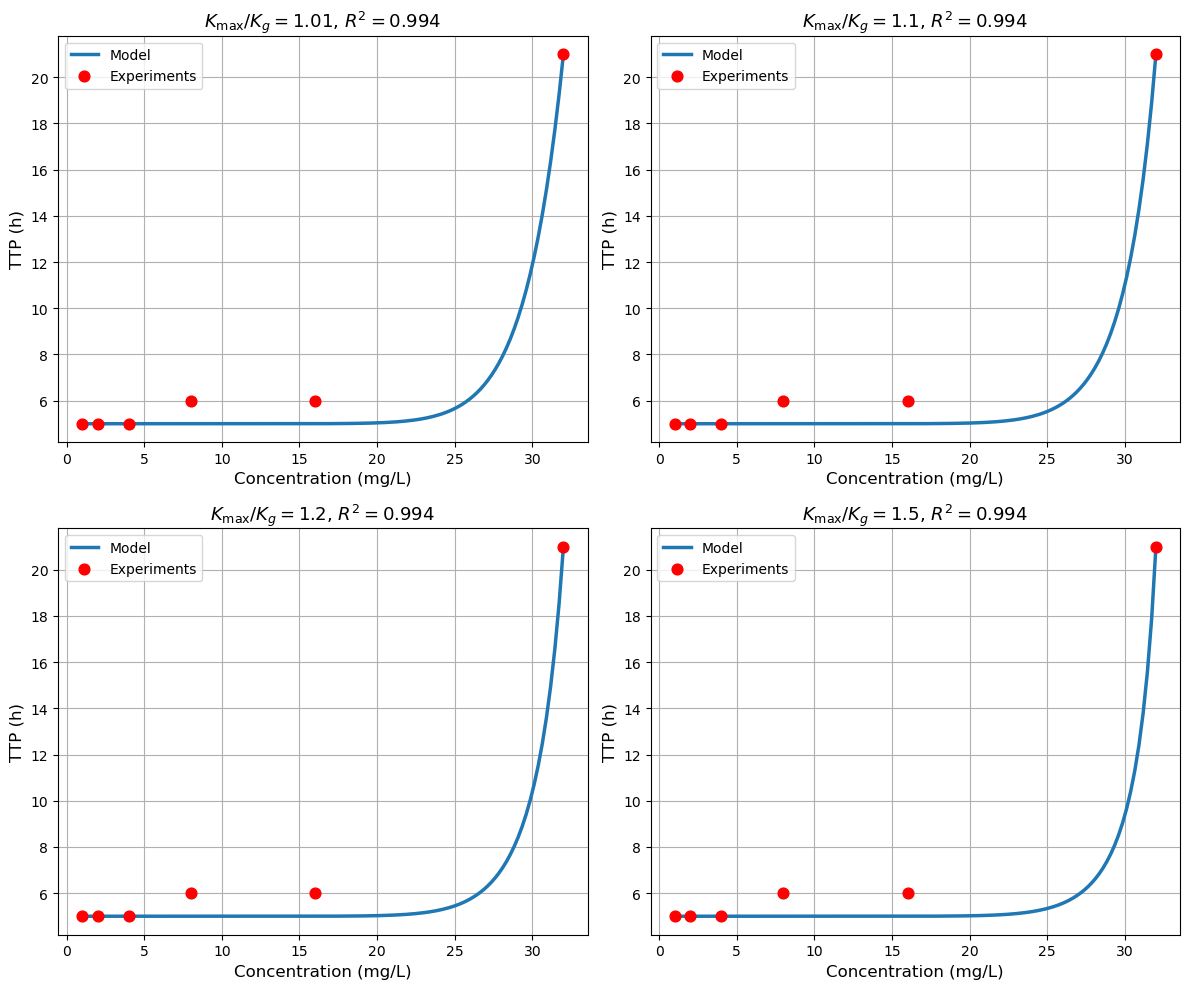

In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds, differential_evolution
from numpy.linalg import inv
from itables import show
import sympy as sp
import warnings
warnings.filterwarnings("ignore")

concentration_data = np.array([1, 2, 4, 8, 16, 32])
TTP_obs = np.array([5, 5, 5, 6, 6, 21])
TTP_0 = 5.0
H_fixed = 12.8

weights = np.ones_like(TTP_obs)
weights[concentration_data == 32] = 5

C, C50_sym, q_sym = sp.symbols('C C50 q')
frac = q_sym * C**H_fixed / (C**H_fixed + C50_sym**H_fixed)
TTP_expr = TTP_0 / (1 - frac)
dTTP_dC50 = sp.diff(TTP_expr, C50_sym)

TTP_func = sp.lambdify((C, C50_sym, q_sym), TTP_expr, 'numpy')
dTTP_func = sp.lambdify((C, C50_sym, q_sym), dTTP_dC50, 'numpy')

def make_model_and_jac_weighted(q_fixed):
    def ttp(C_array, C50_val):
        return TTP_func(C_array, C50_val, q_fixed)
    def residuals(C50_val):
        model_pred = ttp(concentration_data, C50_val)
        res = (model_pred - TTP_obs) / TTP_obs
        return weights * res
    def jacobian(C_array, C50_val):
        dTTP = dTTP_func(C_array, C50_val, q_fixed)
        return (dTTP / TTP_obs) * weights
    return ttp, residuals, jacobian

results = []
plot_data = []
q_values = [1.01, 1.10, 1.20, 1.50]

for q in q_values:
    ttp_fn, res_fn, jac_fn = make_model_and_jac_weighted(q)
    def objective_scalar(x):
        return np.sum(res_fn(x[0])**2)
    global_result = differential_evolution(
        lambda x: objective_scalar(x),
        bounds=[(1e-3, 1000)],
        strategy='best1bin',
        seed=42,
        polish=False
    )
    init_guess = global_result.x
    result_slsqp = minimize(
        lambda x: np.sum(res_fn(x[0])**2),
        x0=init_guess,
        bounds=Bounds([1e-3], [1000]),
        method='SLSQP',
        options={'ftol': 1e-15, 'maxiter': 20000}
    )
    C50_opt = result_slsqp.x[0]
    residual_val = res_fn(C50_opt)
    sigma2 = np.sum(residual_val**2) / (len(residual_val) - 1)
    J = jac_fn(concentration_data, C50_opt).reshape(-1, 1)
    fisher = J.T @ J
    cov = sigma2 * inv(fisher)
    se = np.sqrt(np.diag(cov))[0]
    results.append({
        r"$K_{\mathrm{max}} / K_g$": q,
        r"$C_{50}$ (mg/L)": C50_opt,
        "SE (Jacobian)": se
    })
    C_fine = np.geomspace(concentration_data.min(), concentration_data.max(), 400)
    TTP_fine = ttp_fn(C_fine, C50_opt)
    TTP_fit = ttp_fn(concentration_data, C50_opt)
    r2_val = np.corrcoef(TTP_obs, TTP_fit)[0, 1] ** 2
    plot_data.append((q, C_fine, TTP_fine, TTP_obs, TTP_fit, r2_val))

df_result = pd.DataFrame(results)
show(df_result)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
for ax, (q, C_fine, TTP_fine, TTP_obs_i, TTP_fit_i, r2_val) in zip(axs.flatten(), plot_data):
    ax.plot(C_fine, TTP_fine, '-', lw=2.5, label="Model")
    ax.scatter(concentration_data, TTP_obs_i, c='red', s=60, zorder=5, label="Experiments")
    ax.set_xlabel("Concentration (mg/L)", fontsize=12)
    ax.set_ylabel("TTP (h)", fontsize=12)
    ax.set_title(fr"$K_{{\mathrm{{max}}}} / K_g = {q}$, $R^2 = {r2_val:.3f}$", fontsize=13)
    ax.legend()
    ax.grid()
plt.tight_layout()
plt.show()

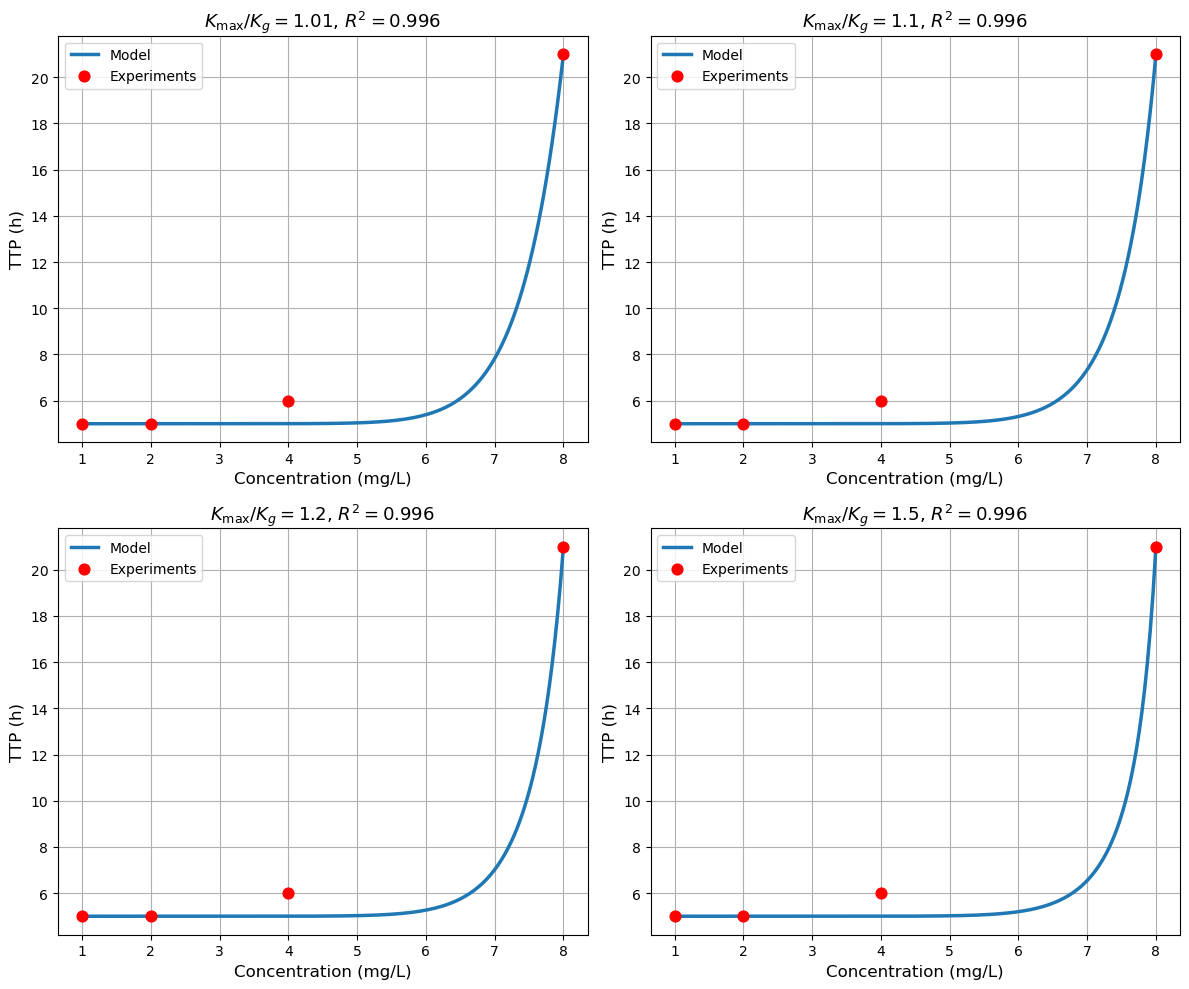

In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds, differential_evolution
from numpy.linalg import inv
from itables import show
import sympy as sp
import warnings
warnings.filterwarnings("ignore")

concentration_data = np.array([1, 2, 4,8])
TTP_obs = np.array([5,5, 6, 21])
TTP_0 = 5.0
H_fixed = 12.8

weights = np.ones_like(TTP_obs)
weights[concentration_data == 8] = 3

C, C50_sym, q_sym = sp.symbols('C C50 q')
frac = q_sym * C**H_fixed / (C**H_fixed + C50_sym**H_fixed)
TTP_expr = TTP_0 / (1 - frac)
dTTP_dC50 = sp.diff(TTP_expr, C50_sym)

TTP_func = sp.lambdify((C, C50_sym, q_sym), TTP_expr, 'numpy')
dTTP_func = sp.lambdify((C, C50_sym, q_sym), dTTP_dC50, 'numpy')

def make_model_and_jac_weighted(q_fixed):
    def ttp(C_array, C50_val):
        return TTP_func(C_array, C50_val, q_fixed)
    def residuals(C50_val):
        model_pred = ttp(concentration_data, C50_val)
        res = (model_pred - TTP_obs) / TTP_obs
        return weights * res
    def jacobian(C_array, C50_val):
        dTTP = dTTP_func(C_array, C50_val, q_fixed)
        return (dTTP / TTP_obs) * weights
    return ttp, residuals, jacobian

results = []
plot_data = []
q_values = [1.01, 1.10, 1.20, 1.50]

for q in q_values:
    ttp_fn, res_fn, jac_fn = make_model_and_jac_weighted(q)
    def objective_scalar(x):
        return np.sum(res_fn(x[0])**2)
    global_result = differential_evolution(
        lambda x: objective_scalar(x),
        bounds=[(1e-3, 1000)],
        strategy='best1bin',
        seed=42,
        polish=False
    )
    init_guess = global_result.x
    result_slsqp = minimize(
        lambda x: np.sum(res_fn(x[0])**2),
        x0=init_guess,
        bounds=Bounds([1e-3], [1000]),
        method='SLSQP',
        options={'ftol': 1e-15, 'maxiter': 20000}
    )
    C50_opt = result_slsqp.x[0]
    residual_val = res_fn(C50_opt)
    sigma2 = np.sum(residual_val**2) / (len(residual_val) - 1)
    J = jac_fn(concentration_data, C50_opt).reshape(-1, 1)
    fisher = J.T @ J
    cov = sigma2 * inv(fisher)
    se = np.sqrt(np.diag(cov))[0]
    results.append({
        r"$K_{\mathrm{max}} / K_g$": q,
        r"$C_{50}$ (mg/L)": C50_opt,
        "SE (Jacobian)": se
    })
    C_fine = np.geomspace(concentration_data.min(), concentration_data.max(), 400)
    TTP_fine = ttp_fn(C_fine, C50_opt)
    TTP_fit = ttp_fn(concentration_data, C50_opt)
    r2_val = np.corrcoef(TTP_obs, TTP_fit)[0, 1] ** 2
    plot_data.append((q, C_fine, TTP_fine, TTP_obs, TTP_fit, r2_val))

df_result = pd.DataFrame(results)
show(df_result)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
for ax, (q, C_fine, TTP_fine, TTP_obs_i, TTP_fit_i, r2_val) in zip(axs.flatten(), plot_data):
    ax.plot(C_fine, TTP_fine, '-', lw=2.5, label="Model")
    ax.scatter(concentration_data, TTP_obs_i, c='red', s=60, zorder=5, label="Experiments")
    ax.set_xlabel("Concentration (mg/L)", fontsize=12)
    ax.set_ylabel("TTP (h)", fontsize=12)
    ax.set_title(fr"$K_{{\mathrm{{max}}}} / K_g = {q}$, $R^2 = {r2_val:.3f}$", fontsize=13)
    ax.legend()
    ax.grid()
plt.tight_layout()
plt.show()

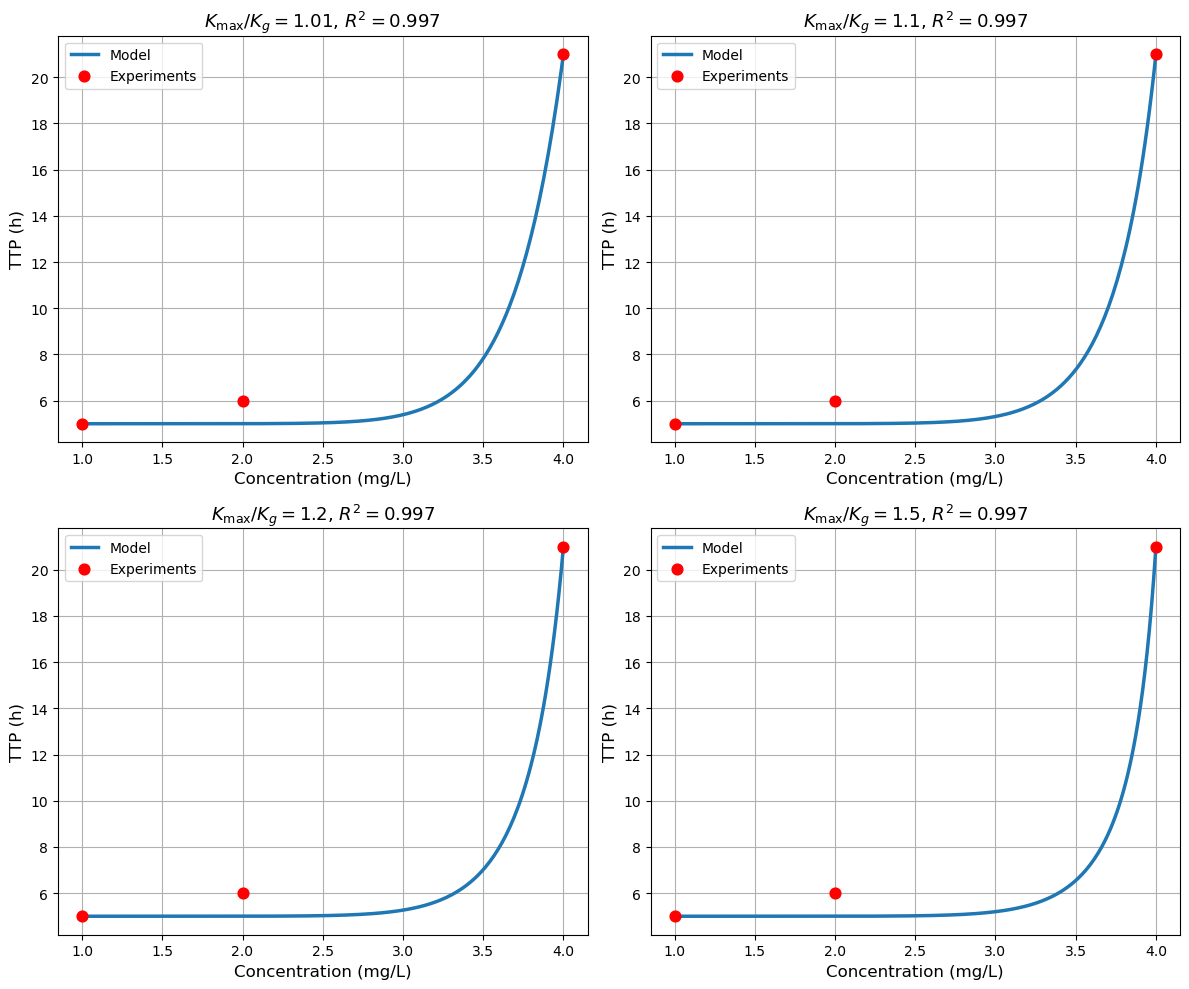

In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds, differential_evolution
from numpy.linalg import inv
from itables import show
import sympy as sp
import warnings
warnings.filterwarnings("ignore")

concentration_data = np.array([1, 2, 4])
TTP_obs = np.array([5, 6, 21])
TTP_0 = 5.0
H_fixed = 12.8

weights = np.ones_like(TTP_obs)
weights[concentration_data == 4] = 5

C, C50_sym, q_sym = sp.symbols('C C50 q')
frac = q_sym * C**H_fixed / (C**H_fixed + C50_sym**H_fixed)
TTP_expr = TTP_0 / (1 - frac)
dTTP_dC50 = sp.diff(TTP_expr, C50_sym)

TTP_func = sp.lambdify((C, C50_sym, q_sym), TTP_expr, 'numpy')
dTTP_func = sp.lambdify((C, C50_sym, q_sym), dTTP_dC50, 'numpy')

def make_model_and_jac_weighted(q_fixed):
    def ttp(C_array, C50_val):
        return TTP_func(C_array, C50_val, q_fixed)
    def residuals(C50_val):
        model_pred = ttp(concentration_data, C50_val)
        res = (model_pred - TTP_obs) / TTP_obs
        return weights * res
    def jacobian(C_array, C50_val):
        dTTP = dTTP_func(C_array, C50_val, q_fixed)
        return (dTTP / TTP_obs) * weights
    return ttp, residuals, jacobian

results = []
plot_data = []
q_values = [1.01, 1.10, 1.20, 1.50]

for q in q_values:
    ttp_fn, res_fn, jac_fn = make_model_and_jac_weighted(q)
    def objective_scalar(x):
        return np.sum(res_fn(x[0])**2)
    global_result = differential_evolution(
        lambda x: objective_scalar(x),
        bounds=[(1e-3, 1000)],
        strategy='best1bin',
        seed=42,
        polish=False
    )
    init_guess = global_result.x
    result_slsqp = minimize(
        lambda x: np.sum(res_fn(x[0])**2),
        x0=init_guess,
        bounds=Bounds([1e-3], [1000]),
        method='SLSQP',
        options={'ftol': 1e-15, 'maxiter': 20000}
    )
    C50_opt = result_slsqp.x[0]
    residual_val = res_fn(C50_opt)
    sigma2 = np.sum(residual_val**2) / (len(residual_val) - 1)
    J = jac_fn(concentration_data, C50_opt).reshape(-1, 1)
    fisher = J.T @ J
    cov = sigma2 * inv(fisher)
    se = np.sqrt(np.diag(cov))[0]
    results.append({
        r"$K_{\mathrm{max}} / K_g$": q,
        r"$C_{50}$ (mg/L)": C50_opt,
        "SE (Jacobian)": se
    })
    C_fine = np.geomspace(concentration_data.min(), concentration_data.max(), 400)
    TTP_fine = ttp_fn(C_fine, C50_opt)
    TTP_fit = ttp_fn(concentration_data, C50_opt)
    r2_val = np.corrcoef(TTP_obs, TTP_fit)[0, 1] ** 2
    plot_data.append((q, C_fine, TTP_fine, TTP_obs, TTP_fit, r2_val))

df_result = pd.DataFrame(results)
show(df_result)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
for ax, (q, C_fine, TTP_fine, TTP_obs_i, TTP_fit_i, r2_val) in zip(axs.flatten(), plot_data):
    ax.plot(C_fine, TTP_fine, '-', lw=2.5, label="Model")
    ax.scatter(concentration_data, TTP_obs_i, c='red', s=60, zorder=5, label="Experiments")
    ax.set_xlabel("Concentration (mg/L)", fontsize=12)
    ax.set_ylabel("TTP (h)", fontsize=12)
    ax.set_title(fr"$K_{{\mathrm{{max}}}} / K_g = {q}$, $R^2 = {r2_val:.3f}$", fontsize=13)
    ax.legend()
    ax.grid()
plt.tight_layout()
plt.show()



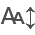

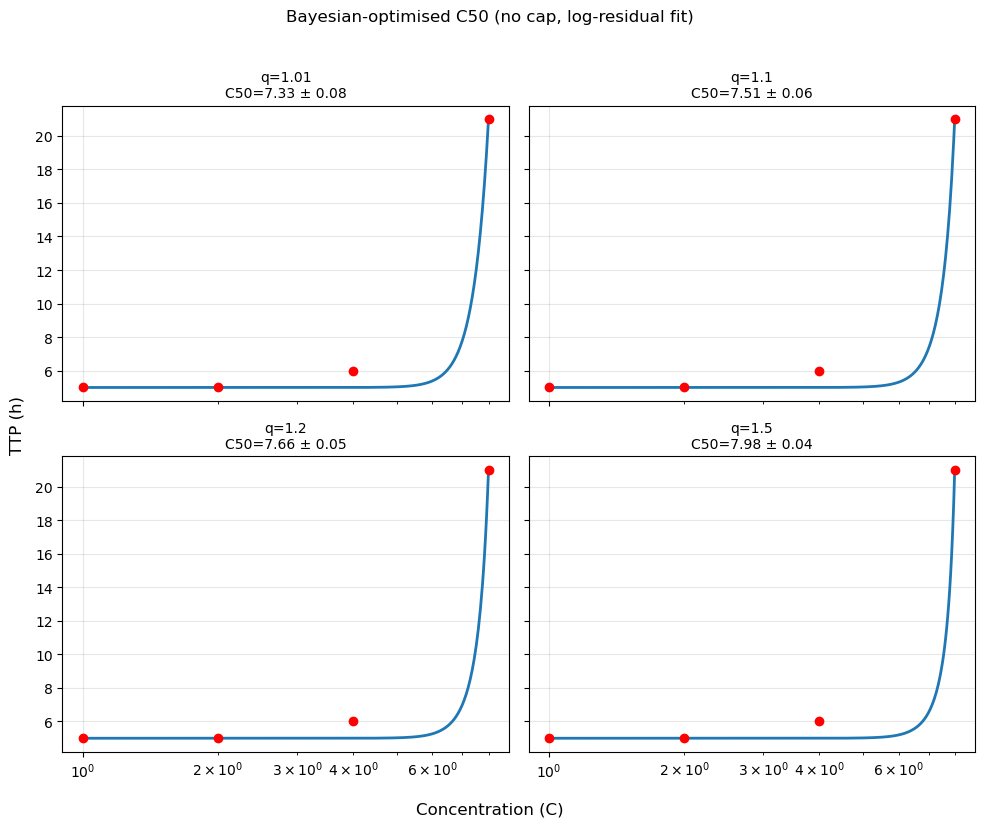

In [56]:
"""
Bayesian optimisation of C50 (no cap, log‑residual objective, NaN‑safe)

• Fixed q values: [1.01, 1.10, 1.20, 1.50]
• Model:   TTP(C) = TTP0 / (1 − q·C^H / (C^H + C50^H))
• Objective:  SSE of log‑residuals  ∑[log(TTP_pred) − log(TTP_obs)]²
              (if any TTP_pred≤0 or non‑finite → huge penalty)
• Bayesian optimiser: 10 random starts  → 40 EI iterations
• Local polish: Nelder–Mead from best EI point
• Analytic SE(C50) from log‑space Jacobian with residual‑based σ²
• Outputs: 2 × 2 panel plot + results table (interactive if itables installed)
"""

# ───────── imports ─────────────────────────────────────────
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as CK, WhiteKernel
from sklearn.exceptions import ConvergenceWarning
import warnings; warnings.filterwarnings("ignore", category=ConvergenceWarning)

try:                                    # interactive table if available
    from itables import show, init_notebook_mode
    init_notebook_mode(all_interactive=True)
    use_itables = True
except ImportError:
    use_itables = False

# ───────── data & constants ───────────────────────────────
C       = np.array([1, 2, 4, 8])
TTP_obs = np.array([5, 5, 6, 21])
T0, H   = 5.0, 12.8
qs      = [1.01, 1.10, 1.20, 1.50]
LARGE   = 1e6                       # penalty for invalid prediction

# ───────── model & Jacobian (w.r.t. C50) ──────────────────
def ttp(C, q, C50):
    frac = q * C**H / (C**H + C50**H)
    denom = 1.0 - frac
    return T0 / denom

def jac_log(C, q, C50):
    num = C**H
    den = num + C50**H
    frac = q * num / den
    dfrac = -q * H * num * C50**(H-1) / den**2
    dlogT = dfrac / (1.0 - frac)            # ∂log(TTP)/∂C50
    return dlogT.reshape(-1, 1)

# ───────── NaN‑safe log‑space SSE objective ──────────────
def sse_log_safe(C50, q):
    pred = ttp(C, q, C50)
    if np.any(pred <= 0) or not np.all(np.isfinite(pred)):
        return LARGE
    res = np.log(pred) - np.log(TTP_obs)
    return np.sum(res**2)

# ───────── expected‑improvement acquisition ───────────────
def expected_improvement(X, gp, y_best, xi=0.01):
    mu, sigma = gp.predict(X, return_std=True)
    with np.errstate(divide='warn'):
        Z  = (y_best - mu - xi) / sigma
        ei = (y_best - mu - xi) * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    return ei

# ───────── simple 1‑D Bayesian optimiser ─────────────────
def bayes_opt_C50(q, bounds=(0.5, 20), n_init=10, n_iter=40, seed=0):
    rng = np.random.default_rng(seed)
    X = rng.uniform(*bounds, size=(n_init, 1))
    y = np.array([sse_log_safe(x[0], q) for x in X])

    kernel = CK(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, nu=2.5) + WhiteKernel(1e-5)
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)

    for _ in range(n_iter):
        gp.fit(X, y)
        X_rand = rng.uniform(*bounds, size=(1000, 1))
        x_next = X_rand[np.argmax(expected_improvement(X_rand, gp, y.min()))]
        y_next = sse_log_safe(x_next[0], q)
        X = np.vstack([X, x_next])
        y = np.append(y, y_next)

    # local polish
    res = minimize(lambda x: sse_log_safe(x, q),
                   x0=[X[np.argmin(y), 0]], bounds=[bounds], method="Nelder-Mead")
    return float(res.x[0])

# ───────── fit all q values ───────────────────────────────
results, C_fine = [], np.geomspace(C.min(), C.max(), 400)
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
axes = axes.ravel()

for ax, q in zip(axes, qs):
    # Bayesian search
    C50_opt = bayes_opt_C50(q, seed=0)

    # residual variance (log‑space)
    res_log = np.log(ttp(C, q, C50_opt)) - np.log(TTP_obs)
    sigma2  = np.sum(res_log**2) / (len(C) - 1)

    # analytic SE
    J_log = jac_log(C, q, C50_opt)
    se = float(np.sqrt(sigma2 * np.linalg.inv(J_log.T @ J_log)[0, 0]))

    results.append({"K_max / K_g": q,
                    "C50 (mg/L)": C50_opt,
                    "SE": se,
                    "C50 ± SE": f"{C50_opt:.2f} ± {se:.2f}"})

    # plot panel
    ax.plot(C_fine, ttp(C_fine, q, C50_opt), lw=2)
    ax.scatter(C, TTP_obs, c='red', zorder=5)
    ax.set_xscale('log'); ax.grid(alpha=0.3)
    ax.set_title(f"q={q}\nC50={C50_opt:.2f} ± {se:.2f}", fontsize=10)

fig.supylabel("TTP (h)")
fig.supxlabel("Concentration (C)")
fig.suptitle("Bayesian‑optimised C50 (no cap, log‑residual fit)", y=1.02)
fig.tight_layout(); plt.show()

# ───────── summary table ────────────────────────────────
df = pd.DataFrame(results).round(3)
if use_itables:
    show(df)
else:
    print(df.to_string(index=False))


In [86]:
import numpy as np, pandas as pd
from scipy.optimize import differential_evolution, least_squares

# ───────── data & constants ──────────────────────────────────────
C, Y = np.array([1, 2, 4, 8]), np.array([5, 5, 6, 21])
T0, H, CAP = 5.0, 12.8, 1.55
qs = [1.01, 1.10, 1.20, 1.50]

# ───────── model & SSE (log space, clipping) ────────────────────
def ttp(C, q, C50):
    # raw Hill fraction
    frac = q * C**H / (C**H + C50**H)
    # clipped fraction
    frac_s = frac * CAP / (CAP + frac)
    return T0 / (1 - frac_s)

def sse_log(C50, q):
    pred = ttp(C, q, C50[0])
    if np.any(pred <= 0) or not np.all(np.isfinite(pred)):
        return 1e9
    # log-residual SSE
    return np.sum((np.log(pred) - np.log(Y))**2)

# ───────── analytic Jacobian of log-TTP w.r.t. C50 ───────────────
def jac_log(C, q, C50):
    num = C**H
    den = num + C50**H
    frac = q * num / den              # raw hill fraction
    # derivative of raw fraction w.r.t. C50
    dfrac = -q * H * num * C50**(H - 1) / den**2

    # compute clipped fraction and its derivative w.r.t. C50
    # frac_s = frac * CAP / (CAP + frac)
    # d(frac_s)/d(C50) = dfrac * [ CAP^2 / (CAP + frac)^2 ]
    common = CAP**2 / (CAP + frac)**2
    dfrac_s = dfrac * common

    # finally: ∂ log(TTP) / ∂ C50 = (1 / TTP) * (∂ TTP / ∂ C50)
    # but since log(TTP) = – log(1 – frac_s) + constant, 
    #     ∂ log(TTP) / ∂ C50 = (dfrac_s) / [1 – frac_s].
    frac_s = frac * CAP / (CAP + frac)
    dlogT = dfrac_s / (1 - frac_s)

    return dlogT.reshape(-1, 1)       # shape (4,1)

# ───────── fit function (global DE + local LS) ─────────────────
def fit_global_then_local(q):
    # 1) global search (DE) over [0.5, 20]
    de = differential_evolution(
        lambda x: sse_log(x, q),
        bounds=[(0.5, 20)], seed=0,
        strategy='best1bin', popsize=20, polish=False
    )
    # 2) local polish in log-space residuals
    ls = least_squares(
        lambda p: np.log(ttp(C, q, p[0])) - np.log(Y),
        jac=lambda p: jac_log(C, q, p[0]),
        x0=de.x, bounds=(0.5, 20)
    )
    C50_opt = ls.x[0]

    # compute residual variance in log-space
    res_log = ls.fun
    sigma2 = np.sum(res_log**2) / (len(C) - 1)

    # analytic SE:  SE = sqrt[ σ² * (Jᵀ J)⁻¹₀₀ ]
    J = ls.jac                     # shape (4,1)
    cov = sigma2 * np.linalg.inv(J.T @ J)
    se = np.sqrt(cov[0, 0])

    return C50_opt, se

# ───────── run for each q, gather results ──────────────────────
rows = []
for q in qs:
    C50_opt, se = fit_global_then_local(q)
    rows.append([f"K_max/K_g = {q}", f"{C50_opt:.2f} ± {se:.2f}"])

df = pd.DataFrame(rows, columns=["q ratio", "C50 ± SE (mg/L)"])
print(df.to_string(index=False))


         q ratio C50 ± SE (mg/L)
K_max/K_g = 1.01     4.49 ± 0.68
 K_max/K_g = 1.1     4.52 ± 0.55
 K_max/K_g = 1.2     4.56 ± 0.42
 K_max/K_g = 1.5     4.66 ± 0.00


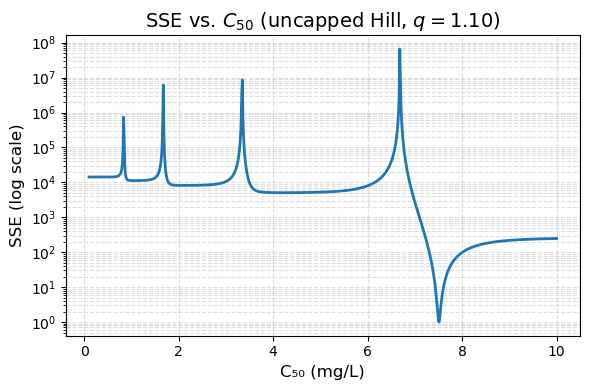

In [96]:
import numpy as np
import matplotlib.pyplot as plt

# ─────────── Data & Constants ───────────
C_all = np.array([1, 2, 4, 8])      # the four concentrations
Y_all = np.array([ 5,  5,  6, 21])  # observed TTP at those four points
T0, H = 5.0, 12.8
q     = 1.10                         # K_max/K_g = 1.10

# ─────────── uncapped Hill TTP (may become negative/infinite) ───────────
def ttp_no_cap(C, C50):
    """
    Raw Hill model without any clipping/cap:
      f_raw = q * C^H / (C^H + C50^H)
      TTP   = T0 / (1 - f_raw)
    If 1 - f_raw <= 0, TTP goes negative or blows up (∞).
    We do NOT filter or penalize—just let it compute whatever it is.
    """
    frac_raw = q * C**H / (C**H + C50**H)
    return T0 / (1 - frac_raw)

# ─────────── SSE over all four points (including C=8) ───────────
def sse_full(C50):
    """
    Compute sum of squared errors for all four data points:
      SSE = ∑[TTP_no_cap(C_i; C50) - Y_i]^2,  i=1,2,4,8.
    Even if some TTP_no_cap(...) is negative or huge, we square it
    and keep a finite SSE.
    """
    pred = ttp_no_cap(C_all, C50)   # shape = (4,)
    return np.sum((pred - Y_all)**2)

# ─────────── Build SSE vs C50 on a grid ───────────
C50_vals = np.linspace(0.1, 10, 800)            # C50 from 0.1 to 10
SSE_vals  = np.array([sse_full(c) for c in C50_vals])

# ─────────── Plot only the first (log‐scale) panel ───────────
plt.figure(figsize=(6, 4))
plt.plot(C50_vals, SSE_vals, color='tab:blue', lw=2)
plt.yscale('log')
plt.xlabel("C₅₀ (mg/L)", fontsize=12)
plt.ylabel("SSE (log scale)", fontsize=12)
plt.title(r"SSE vs. $C_{50}$ (uncapped Hill, $q=1.10$)", fontsize=14)
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.tight_layout()
plt.show()
